# Homework 3 - Analyzing a Movie Review Dataset Part 2

## 1.Word2Vec

In [7]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np
from gensim.models import Word2Vec,KeyedVectors
import nltk
pd.set_option('max_colwidth',400)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

In [3]:
def get_words( review ):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    return(words)

In [4]:
def get_sentences( review ):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append( get_words( raw_sentence ))
    return sentences

In [5]:
sentences = []
for review in train["review"]:
    sentences += get_sentences(review)
for review in unlabeled_train["review"]:
    sentences += get_sentences(review)

In [32]:
all_words = []
for rev in train["review"]:
    all_words.extend(get_words(rev))
for rev in unlabeled_train["review"]:
    all_words.extend(get_words(rev))    

In [131]:
print("Number of sentences to train the word 2 vec model ",len(sentences))

Number of sentences to train the word 2 vec model  795538


## 1 A - Creating Z1


In [7]:
context = 5    
embedding_dimension = 100                    
min_words = 40                                                                                                              
model = Word2Vec(sentences, size = embedding_dimension, min_count = min_words, window = context)
model.init_sims(replace=True)
model_name = "word2vec"
model.save(model_name)
model = Word2Vec.load("word2vec")
Z1 = model.wv.syn0
print ("Shape of Z1 : ",model.wv.syn0.shape)

Shape of Z1 :  (16490, 100)


## 1 B - Creating Z2

In [28]:
model_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [38]:
Z2_list = []
words_Z2 = []
i = 0
all_words = set(all_words)
for key, elem in model_google.vocab.items():
    if key in all_words:
        words_Z2.append(key)
        Z2_list.append(model_google.syn0[i])
    i+=1  

In [39]:
len(all_words)

123504

In [40]:
Z2=np.array(Z2_list)

In [41]:
print ("Converted from ",model_google.syn0.shape," to ",Z2.shape)
print ("Shape of Z2 : ",Z2.shape)

Converted from  (3000000, 300)  to  (65267, 300)
Shape of Z2 :  (65267, 300)


## 1 C - K Means

### K-Means for Z1

In [71]:
from sklearn.cluster import KMeans
from numpy import linalg as LA
kmeans_clustering = KMeans( n_clusters = 10 )
idx = kmeans_clustering.fit_predict( Z1 )
map_word = dict(zip( model.wv.index2word, idx ))

In [25]:
cluster_words = [[] for i in range(10)]
i = 0
for key, elem in model.wv.vocab.items():
    cluster_ind = map_word[key]
    center = kmeans_clustering.cluster_centers_[cluster_ind] 
    dist = np.linalg.norm(center-Z1[i])
    cluster_words[cluster_ind].append((key,dist))
    i+=1  

In [26]:
cluster_nums = []
cluster_w = []

for cluster_num in range(0,10):
    words = []
    k = sorted(cluster_words[cluster_num], key=lambda tup: tup[1])[:20]
    for i,j in k:
        words.append(i)
    cluster_nums.append(cluster_num)
    cluster_w.append(words)
    
output = pd.DataFrame( data={"cluster":cluster_nums, "clustered_words":cluster_w} )
output

,cluster,clustered_words
0,0,"[figure, betray, choose, attain, contradict, belong, lead, entice, candle, fund, support, bet, forbid, ponder, repeat, conjure, amongst, inflict, take, attend]"
1,1,"[assassinated, mcdowell, bickford, skywalker, stacey, kirby, rebecca, wellman, patton, myrna, oldman, moreau, kira, impersonation, kevin, slater, greenstreet, cristina, lever, abigail]"
2,2,"[lately, originally, moviegoer, tv, creators, i, period, info, aired, efforts, viewings, differently, prude, errors, off, hadn, thousand, fiction, above, again]"
3,3,"[aptly, micro, lenzi, jazz, brightest, gilligan, peyton, signature, resurrection, limbo, tag, prelude, mimzy, animator, trinity, quintessential, noir, roach, wb, sting]"
4,4,"[boy, sheep, rents, defender, obsessive, drowning, imaginary, vixen, devious, psychopathic, beaver, daddy, hallucination, antithesis, hubby, whose, assailant, nanny, wed, stalker]"
5,5,"[occasionally, harshly, distorted, erratic, fantastically, patronizing, colors, idealized, flashy, thorough, modified, marvelous, scathing, leisurely, carefully, ridiculous, painful, ambiance, hopeless, dialogs]"
6,6,"[signs, secrets, contrasting, questioning, demeanor, gender, conceit, objection, trappings, selfishness, wallop, defying, depictions, denial, shape, disdain, mechanics, prestige, usage, influence]"
7,7,"[wandering, shove, sheets, ride, midgets, cafe, heads, floors, branches, pizza, skeletons, creep, roller, toxic, throws, swing, desert, chair, grenade, running]"
8,8,"[humiliated, damaged, restored, informing, received, destroyed, claims, diminished, encouraged, stopped, exposing, matured, gains, classified, tackled, propelled, has, explores, imagines, devised]"
9,9,"[partition, group, pyramid, principals, workers, labor, gathering, outpost, ghosts, globe, spirits, mutant, behalf, houses, budapest, grandparents, bunker, dancers, wolves, afterlife]"


### K-Means for Z2

In [42]:
kmeans_clustering_Z2 = KMeans( n_clusters = 10 )
idx_Z2 = kmeans_clustering_Z2.fit_predict( Z2 )
map_word_Z2 = dict(zip( words_Z2, idx_Z2 ))

In [43]:
cluster_words = [[] for i in range(10)]
i = 0
for key in words_Z2:
    cluster_ind = map_word_Z2[key]
    center = kmeans_clustering_Z2.cluster_centers_[cluster_ind] 
    dist = np.linalg.norm(center-Z2[i])
    cluster_words[cluster_ind].append((key,dist))
    i+=1  

In [44]:
cluster_nums = []
cluster_w = []

for cluster_num in range(0,10):
    words = []
    k = sorted(cluster_words[cluster_num], key=lambda tup: tup[1])[:20]
    for i,j in k:
        words.append(i)
    cluster_nums.append(cluster_num)
    cluster_w.append(words)
    
output2 = pd.DataFrame( data={"cluster":cluster_nums, "clustered_words":cluster_w} )
output2

,cluster,clustered_words
0,0,"[ahn, mew, unfulfillment, minions, resigning, editors, poppa, ooohh, narc, egghead, capability, blinders, replacements, impersonalized, coasting, ascerbic, assaulting, tolerated, exiled, trellises]"
1,1,"[enforce, reccomendations, humiliates, hotline, armistice, eardrum, omaha, democratic, brutalizes, european, vanquishing, recruitment, poche, substantiates, memorize, granted, northwest, tars, hypermodern, tomato]"
2,2,"[fakest, suffices, exhaling, arc, turnable, arrant, afterbirth, colonialism, nds, ig, pooled, target, assignations, jul, venturing, bugling, blowhards, gente, mister, licorice]"
3,3,"[cryptologists, fanbases, soliloquies, halfway, bubbling, superthin, marbled, slowdown, unbelivable, curmudgeon, dangle, blimps, reduction, klein, sod, fanfare, imitations, tunnel, larvae, bootlegger]"
4,4,"[razz, hypothesizing, lemony, trashy, gans, boyer, gurgling, zippers, assure, pinewood, ricerca, varsity, vacant, reads, concorde, leach, cartels, transforms, reels, cognitive]"
5,5,"[unselective, connoting, marshmallows, divinities, introduces, muzhik, endorses, gills, undeclared, unsociable, peerless, concede, nighttime, recliners, disservice, lattes, babirusa, swiftness, beguiles, shyest]"
6,6,"[subsp, savoy, supplement, acclaims, jarred, erupt, flagrant, wiley, refocus, spokes, translater, boiling, bon, affirmation, scarier, overexert, consistent, tortoise, carriers, uprising]"
7,7,"[torre, nightingales, decider, mismatch, jointed, especialy, moxy, cking, caymans, uncouth, walkabout, uninventive, phoney, giggling, gracing, calves, servile, reflex, puhleeze, paste]"
8,8,"[ahm, buffett, dhoom, lawsuits, washing, decorous, undreamed, possessor, socko, marshal, eligible, spewer, schema, coterie, lionel, filmi, submitted, hugging, sonic, sweetener]"
9,9,"[dustiest, intermittently, handkerchiefs, hen, ravine, forthrightness, zanies, rocketship, ei, marshy, daftness, secuirty, stingers, drowning, squeezable, womanizers, aestheticians, suckerpunch, rite, dad]"


# 1 D - X1, X2

In [45]:
def get_bag( review, map_word ):
    c = 10
    bag = np.zeros( c, dtype="float32" )
    for word in review:
        if word in map_word:
            index = map_word[word]
            bag[index] += 1
    return bag

In [46]:
train_r = []
for rev in train["review"]:
    train_r.append(get_words(rev))

test_r = []
for rev in test["review"]:
    test_r.append(get_words(rev))

In [52]:
X1 = np.zeros( (train["review"].size, 10), dtype="float32" )
c = 0
for review in train_r:
    X1[c] = get_bag( review, map_word )
    c += 1

kaggle_test_1 = np.zeros(( test["review"].size, 10), dtype="float32" )

c = 0
for review in test_r:
    kaggle_test_1[c] = get_bag( review, map_word )
    c += 1

X2 = np.zeros( (train["review"].size, 10), dtype="float32" )
c = 0
for review in train_r:
    X2[c] = get_bag( review, map_word_Z2 )
    c += 1

kaggle_test_2 = np.zeros(( test["review"].size, 10), dtype="float32" )

c = 0
for review in test_r:
    kaggle_test_2[c] = get_bag( review, map_word_Z2 )
    c += 1

In [70]:
print ("X1      ",X1.shape)
print ("X1 test ",kaggle_test_1.shape)
print ("X2      ",X2.shape)
print ("X2 test ",kaggle_test_2.shape)
np.save('X1',X1)
np.save('X1_test', kaggle_test_1)
np.save('X2', X2)
np.save('X2_test', kaggle_test_2)

X1       (25000, 10)
X1 test  (25000, 10)
X2       (25000, 10)
X2 test  (25000, 10)


In [3]:
import numpy as np
X1 = np.load('X1.npy')
kaggle_test_1 = np.load('X1_test.npy')
# X2 = np.load('X2.npy')
# kaggle_test_2 = np.load('X2_test.npy')

# 2 LDA

In [12]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

dictionary = corpora.Dictionary(train_r)

In [13]:
doc_term_matrix = [dictionary.doc2bow(review) for review in train_r]

In [14]:
from nltk.corpus import stopwords # Import the stop word list

## 10 Topics

In [17]:
ldamodel = LdaModel(doc_term_matrix, num_topics=10, id2word = dictionary, passes=20)

In [19]:
cluster_nums = []
cluster_words = []

for cluster_num in range(0,10):
    words = []
    for key, elem in ldamodel.show_topic(cluster_num,100):
        if key not in stopwords.words("english"):
            words.append(key)
    cluster_nums.append(cluster_num)
    cluster_words.append(words[:10])
    
output_X3 = pd.DataFrame( data={"cluster":cluster_nums, "clustered_words":cluster_words} )
output_X3

,cluster,clustered_words
0,0,"[show, series, episode, version, tv, episodes, season, music, songs, musical]"
1,1,"[gandhi, che, hitler, macarthur, zizek, la, de, harilal, amrita, creasy]"
2,2,"[like, one, bad, movie, get, even, make, people, really, guy]"
3,3,"[woman, girl, husband, actress, mother, daughter, women, sister, boyfriend, young]"
4,4,"[movie, like, good, one, really, see, film, would, movies, time]"
5,5,"[film, one, story, films, characters, well, much, like, even, character]"
6,6,"[one, man, life, film, love, great, role, family, young, also]"
7,7,"[action, one, killer, also, good, horror, police, movie, john, fight]"
8,8,"[batman, superman, king, match, jackson, elvis, animated, animation, lion, cartoon]"
9,9,"[people, war, world, one, would, us, time, first, american, new]"


## 20 Topics

In [20]:
ldamodel_20 = LdaModel(doc_term_matrix, num_topics=20, id2word = dictionary, passes=20)

In [22]:
cluster_nums = []
cluster_words = []

for cluster_num in range(0,20):
    words = []
    for key, elem in ldamodel_20.show_topic(cluster_num,100):
        if key not in stopwords.words("english"):
            words.append(key)
    cluster_nums.append(cluster_num)
    cluster_words.append(words[:10])
    
output_X4 = pd.DataFrame( data={"cluster":cluster_nums, "clustered_words":cluster_words} )
output_X4

,cluster,clustered_words
0,0,"[woman, actress, husband, role, girl, character, mother, performance, daughter, lady]"
1,1,"[love, family, girl, comedy, old, young, movie, two, little, one]"
2,2,"[film, movie, good, one, story, well, like, films, much, great]"
3,3,"[christmas, rock, band, santa, chuck, ned, jim, cube, bugs, carrey]"
4,4,"[disney, cartoon, animation, keaton, animated, king, cinderella, cartoons, cat, jerry]"
5,5,"[sinatra, page, football, bettie, garbo, frank, salman, vivian, gable, beckham]"
6,6,"[show, series, episode, tv, episodes, season, shows, television, characters, first]"
7,7,"[man, one, wife, get, back, gets, also, character, plays, time]"
8,8,"[movie, like, one, would, see, really, film, good, think, time]"
9,9,"[jackie, chan, adam, sandler, smith, elvis, burton, bollywood, indian, kapoor]"


In [27]:
def get_probs( review, model, dictionary,c ):
    bag = np.zeros( c, dtype="float32" )
    for i,j in model.get_document_topics(dictionary.doc2bow(review)):
        bag[i] = j
    return bag

In [34]:
X3 = np.zeros( (train["review"].size, 10), dtype="float32" )
c = 0
for review in train_r:
    X3[c] = get_probs( review, ldamodel, dictionary,10 )
    c += 1

kaggle_test_3 = np.zeros(( test["review"].size, 10), dtype="float32" )

c = 0
for review in test_r:
    kaggle_test_3[c] = get_probs( review, ldamodel, dictionary,10 )
    c += 1

X4 = np.zeros( (train["review"].size, 20), dtype="float32" )
c = 0
for review in train_r:
    X4[c] = get_probs( review, ldamodel_20, dictionary , 20)
    c += 1

kaggle_test_4 = np.zeros(( test["review"].size, 20), dtype="float32" )

c = 0
for review in test_r:
    kaggle_test_4[c] =  get_probs( review, ldamodel_20, dictionary , 20)
    c += 1

In [35]:
print ("X3      ",X3.shape)
print ("X3 test ",kaggle_test_3.shape)
print ("X4      ",X4.shape)
print ("X4 test ",kaggle_test_4.shape)
np.save('X3',X3)
np.save('X3_test', kaggle_test_3)
np.save('X4', X4)
np.save('X4_test', kaggle_test_4)

X3       (25000, 10)
X3 test  (25000, 10)
X4       (25000, 20)
X4 test  (25000, 20)


In [60]:
X3 = np.load('X3.npy')
kaggle_test_3 = np.load('X3_test.npy')
X4 = np.load('X4.npy')
kaggle_test_4 = np.load('X4_test.npy')

# 3 Classification

In [5]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [50]:
def gridsearch(X):
    trainX, testX, trainY, testY = train_test_split(X, train["sentiment"], test_size=0.2, random_state=0)
    clf = RandomForestClassifier(random_state=0)
    scoring = 'roc_auc'
    param_grid = {'n_estimators': [75, 100],
                  'max_features': ['auto', 'log2',None, 0.4],
                  'min_samples_leaf':[1, 10, 20],
                  'max_depth':[None, 35, 70, 100],
                  "bootstrap": [True, False],
                  'min_samples_split':[2, 8, 16],
                  "criterion": ["gini", "entropy"]}
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring = scoring,  n_jobs=-1, verbose=3)
    grid_search.fit(trainX, trainY)
    predY = grid_search.predict(testX)
    acc = accuracy_score(testY, predY)
    probs = grid_search.predict_proba(testX)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(testY, preds)
    roc_auc = metrics.auc(fpr, tpr)
    return grid_search,fpr,tpr,acc,roc_auc

# Classifier 1

In [64]:
#grid_search1,fpr1,tpr1,acc1,roc_auc1 = gridsearch(X1)
print ('Accuracy :',acc1,'\nAUC :',roc_auc1)

Accuracy : 0.6376 
AUC : 0.684367965407


# Classifier 2

In [56]:
#grid_search2,fpr2,tpr2,acc2,roc_auc2 = gridsearch(X2)
print ('Accuracy :',acc2,'\nAUC :',roc_auc2)

Accuracy : 0.5788 
AUC : 0.620224479552


# Classifier 3

In [66]:
#grid_search3,fpr3,tpr3,acc3,roc_auc3 = gridsearch(X3)
print ('Accuracy :',acc3,'\nAUC :',roc_auc3)

Accuracy : 0.7196 
AUC : 0.79281418302


# Classifier 4

In [68]:
#grid_search4,fpr4,tpr4,acc4,roc_auc4 = gridsearch(X4)
print ('Accuracy :',acc4,'\nAUC :',roc_auc4)

Accuracy : 0.8354 
AUC : 0.906687521288


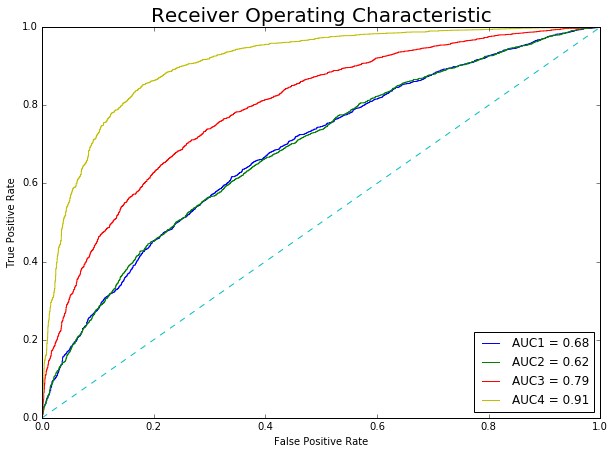

In [69]:
#Plot ROC Curve
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.plot(fpr1, tpr1, 'b', label = 'AUC1 = %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'g', label = 'AUC2 = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'r', label = 'AUC3 = %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'y', label = 'AUC4 = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'c--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Kaggle

In [50]:
M1 = RandomForestClassifier(bootstrap=True, 
                            criterion= 'entropy',
                            max_depth = 35, 
                            max_features = 'log2', 
                            min_samples_leaf = 20, 
                            min_samples_split = 16, 
                            n_estimators = 100)

M1 = M1.fit(X1, train["sentiment"])
Y1 = M1.predict(kaggle_test_1)

output = pd.DataFrame( data={"id":test["id"], "sentiment":Y1} )
output.to_csv( "X1_kaggle.csv", index=False, quoting=3 )

Classifier 1 Kaggle score : 0.62560

<img src="X1.PNG">

In [57]:
M2 = RandomForestClassifier(bootstrap=True, 
                            criterion= 'entropy',
                            max_depth = 35, 
                            max_features = 'auto', 
                            min_samples_leaf = 20, 
                            min_samples_split = 16, 
                            n_estimators = 100)
M2 = M2.fit(X2, train["sentiment"])
Y2 = M2.predict(kaggle_test_2)

output = pd.DataFrame( data={"id":test["id"], "sentiment":Y2} )
output.to_csv( "X2_kaggle.csv", index=False, quoting=3 )

Classifier 2 Kaggle score : 0.5812

<img src="X2.PNG">

In [52]:
M3 = RandomForestClassifier(bootstrap=True, 
                            criterion= 'entropy',
                            max_depth = 70, 
                            max_features = 'auto', 
                            min_samples_leaf = 20, 
                            min_samples_split = 16, 
                            n_estimators = 100)
M3 = M3.fit(X3, train["sentiment"])
Y3 = M3.predict(kaggle_test_3)

output = pd.DataFrame( data={"id":test["id"], "sentiment":Y3} )
output.to_csv( "X3_kaggle.csv", index=False, quoting=3 )

Classifier 3 Kaggle score : 0.69324

<img src="X3.PNG">

In [55]:
M4 = RandomForestClassifier(bootstrap=True, 
                            criterion= 'gini',
                            max_depth = 35, 
                            max_features = 'log2', 
                            min_samples_leaf = 10, 
                            min_samples_split = 8, 
                            n_estimators = 100)
M4 = M4.fit(X4, train["sentiment"])
Y4 = M4.predict(kaggle_test_4)

output = pd.DataFrame( data={"id":test["id"], "sentiment":Y4} )
output.to_csv( "X4_kaggle.csv", index=False, quoting=3 )

Classifier 4 Kaggle score : 0.82604

<img src="X4.PNG">

## 3 C
Which featurization technique works best for sentiment classification? Is this better or worse than the simple bag-of-words approach? What are at least three things you could do to improve the efficacy of the classifier?

#### Which featurization technique works best for sentiment classification?

* Among the above 4 featurization techniques, LDA for 20 topics (M4 classifier) works best with an AUC of 90% on train test split data followed by LDA for 10 topics AUC ~80% for train test split data. Word2Vector using the google news model performs the worst AUC ~60% for train test split data. 
* The Kaggle scores were also reflecting the same ranking. M4 classifier gave the highest score of 82% followed by M3 ~70%, M1 ~62% and M2 ~58%.
* LDA model with 20 topics and 10 topics were trained with number of passes = 20 which took time to create but performed significantly better. If we increase the number of topics then the performace will further increase.
* Google word2vec performed the worst. This could be because using news trained model over movie reviews have less overlapping. 
* Also the number of clusters being set to 10 combines many unsimilar words also together dimininshing the value of the word. 
* Over this, I removed words from the google word2vec model that were not required as a preprocessing step. 

#### Is this better or worse than the simple bag-of-words approach? 
* We implemented the simple bag of words in homework 1 which had auc of 80%-90% on train test split data. The kaggle score was also 80%. 
* This shows that simple bag of words was better than word2vec but it is on par with respect to LDA. Although word2vec and lda are powerful methods for sentiment classification, we cannot compare them directly as the number of features we used is 10 or 20 compared to the 5000 we used in homework1. 
* Kmeans with higher number of clusters will drastically improve the performace. As mentioned using a pretrained google model on news with unrequired words removed might not be the best choice for moview review classification. 
* LDA model trained on the training data corpus performed well with a kaggle score of 82% in spite of the reduced number of features!

#### What are at least three things you could do to improve the efficacy of the classifier?
* Increase the number of features more than 10/20. We definitely need to have features in 100s to expect good performace.
* Using batch LDA instead of online LDA that we used here. In online the model is incrementally trained depending on the data. In batch LDA all the data is seen at once.
* Using TF-IDF weights to create the corpus for LDA model instead of bag of words method so as to allocate appropriate weights to rare topics and frequent ones might help in making the performace better.


In [8]:
M1 = RandomForestClassifier(bootstrap=True, 
                            criterion= 'entropy',
                            max_depth = 35, 
                            max_features = 'log2', 
                            min_samples_leaf = 20, 
                            min_samples_split = 16, 
                            n_estimators = 100)

trainX, testX, trainY, testY = train_test_split(X1, train["sentiment"], test_size=0.2, random_state=0)

M1 = M1.fit(trainX,trainY)
predY = M1.predict(testX)

acc = accuracy_score(testY, predY)
probs = M1.predict_proba(testX)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(testY, preds)
roc_auc = metrics.auc(fpr, tpr)

In [9]:
fpr, tpr

(array([  0.00000000e+00,   0.00000000e+00,   3.92464678e-04, ...,
          9.98430141e-01,   9.98430141e-01,   1.00000000e+00]),
 array([  4.07830343e-04,   4.89396411e-03,   4.89396411e-03, ...,
          9.99592170e-01,   1.00000000e+00,   1.00000000e+00]))

In [10]:
fpr

array([  0.00000000e+00,   0.00000000e+00,   3.92464678e-04, ...,
         9.98430141e-01,   9.98430141e-01,   1.00000000e+00])